# ¿Cómo podemos predecir el sentimiento asociado con una interacción con el cliente?

In [1]:
import numpy as np
import pandas as pd
import os
import nltk
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
rcParams['figure.figsize'] = 30, 60

%matplotlib inline

## Introduccion

**Contexto comercial.** Eres un científico de datos para una gran empresa de comercio electrónico. Tienes decenas de miles de clientes que escriben reseñas sobre productos cada día. Cada revisión contiene comentarios textuales junto con un sistema de calificación de 1 a 5 estrellas (siendo 1 la menos satisfecha y 5 la más satisfecha). También tiene un equipo de atención al cliente que interactúa con los clientes a través de servicios de llamadas y mensajes. Su empresa también recopila comentarios sobre las experiencias de sus clientes con la interacción del sitio web después de cada compra. Ni este comentario ni el servicio de mensajería tienen un número de calificación. La empresa quiere cuantificar la satisfacción del cliente proveniente de estas interacciones no calificadas para ayudar con futuras decisiones comerciales (por ejemplo, determinar qué tan bien se están desempeñando sus diversos agentes de servicio al cliente).

**Problema comercial.** Su tarea es **construir modelos que puedan identificar el sentimiento (positivo o negativo) de cada una de estas interacciones no clasificadas**.

**Contexto analítico.** Los datos son un conjunto de reseñas en formato de archivo CSV. Combinaremos lo que aprendimos sobre el procesamiento de texto y los modelos de clasificación para desarrollar algoritmos capaces de clasificar las interacciones por sentimiento.

El caso está estructurado de la siguiente manera: 1) leeremos y analizaremos los datos del texto de entrada y las variables de respuesta correspondientes (calificaciones); 2) realizaremos un preprocesamiento básico para preparar los datos para el modelado; 3) aprenderemos y aplicaremos varias formas de caracterizar el texto de reseñas; y finalmente 4) construiremos modelos de aprendizaje automático para clasificar el texto como mostrando un sentimiento positivo o negativo (1 o 0).

## Leyendo la data


In [2]:
amazon_reviews = pd.read_csv('Reviews.csv')
## Elegimos solo los primeros 10000 por memoria
amazon_reviews = amazon_reviews[:10000]
## Cambiando los nombres de las columnas para que no tengan puntos (.)
amazon_reviews.columns = [each.replace(".","_") for each in amazon_reviews.columns]

Veamos la distribución del número de palabras por reseña:

<AxesSubplot:>

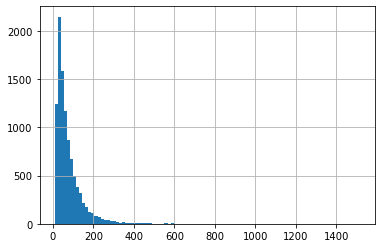

In [3]:
words_per_review = amazon_reviews.Text.apply(lambda x: len(x.split(" ")))
words_per_review.hist(bins = 100)

In [4]:
words_per_review.mean()

77.9028

Ahora miremos la distribucion de los ratings:

In [5]:
amazon_reviews.Score.value_counts()

5    6183
4    1433
1     932
3     862
2     590
Name: Score, dtype: int64

In [6]:
percent_val = 100 * amazon_reviews.Score.value_counts()/amazon_reviews.shape[0]
percent_val

5    61.83
4    14.33
1     9.32
3     8.62
2     5.90
Name: Score, dtype: float64

<AxesSubplot:>

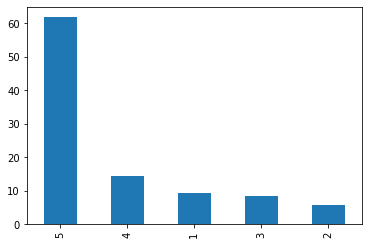

In [7]:
percent_val.plot.bar()

La distribución es bastante sesgada, con un gran número de 5 y muy pocos 3, 2 y 1.

### Ejercicio 1

Cree una nube de palabras para las reseñas de productos.

4157740


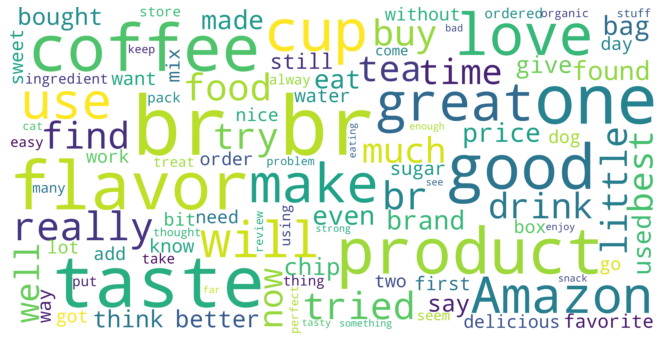

In [9]:
word_cloud_text = ''.join(amazon_reviews.Text[:10000])
print(len(word_cloud_text))
wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white",\
                          scale = 10,width=800, height=400).generate(word_cloud_text)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

La nube de palabras indica que muchas de las reseñas hablan de cosas relacionadas con la comida: café, sabor, comida, sabor, bebida. También vemos algunas palabras positivas como bueno, amor, mejor.

### Estandarización de ratings para análisis de sentimiento

Para fines de análisis de sentimiento, convertiremos todas las calificaciones en valores binarios utilizando la siguiente regla: las calificaciones de 4 o 5 se asignarán a 1, las calificaciones de 1 o 2 se asignarán a 0 y las calificaciones de 3 se dejaran por fuera.

In [10]:
amazon_reviews['Sentiment_rating'] = np.where(amazon_reviews.Score > 3,1,0)
amazon_reviews['Sentiment_rating'].value_counts()

1    7616
0    2384
Name: Sentiment_rating, dtype: int64

In [11]:
##Removiendo la categoria neutral por ahora
amazon_reviews = amazon_reviews[amazon_reviews.Score != 3]

<AxesSubplot:>

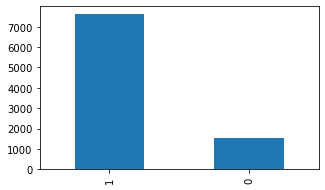

In [12]:
rcParams['figure.figsize'] = 5, 3
amazon_reviews.Sentiment_rating.value_counts().plot.bar()

## Pre-procesamiento

Como se discutió anteriormente, el preprocesamiento y la normalización del texto son cruciales antes de construir un modelo NLP adecuado. Algunos de los pasos importantes son:

1. convertir palabras a minúsculas/mayúsculas
2. eliminar caracteres especiales
3. eliminar palabras vacías y palabras de alta/baja frecuencia
4. Stemming/lematización

Procedamos en orden. Comencemos convirtiendo todas las palabras en un formato de mayúsculas y minúsculas consistente, digamos en minúsculas:

In [13]:
amazon_reviews['reviews_text_new'] = amazon_reviews.Text.apply(lambda x: x.lower())

In [14]:
from nltk import word_tokenize

token_lists = [word_tokenize(each) for each in amazon_reviews.Text]
tokens = [item for sublist in token_lists for item in sublist]
print("Numero de tokens unicos antes: ",len(set(tokens)))

token_lists_lower = [word_tokenize(each) for each in amazon_reviews.reviews_text_new]
tokens_lower = [item for sublist in token_lists_lower for item in sublist]
print("Numero de token unicos ahora: ",len(set(tokens_lower)))

Numero de tokens unicos antes:  27510
Numero de token unicos ahora:  22474


In [17]:
(27510-22474)/22474*100

22.408116045207795

La cantidad de tokens se ha reducido en ~22% solo por normalizar el caso.

### Ejercicio 2

¿Es la eliminación de caracteres especiales incluso una buena idea? ¿Cuáles son algunos ejemplos de caracteres que probablemente sería seguro eliminar y cuáles no?

**Respuesta.** Eliminar caracteres especiales es una decisión subjetiva, especialmente en casos como este. Las personas a menudo usan caracteres especiales para expresar sus emociones y pueden dejar una reseña como _'¡Este producto es el peor!'_, mientras que una reseña positiva podría ser _'¡Este producto es el mejor! ¡Me encantó!'_ Aquí, la presencia de signos de exclamación indica claramente algo sobre el sentimiento subyacente, por lo que eliminarlos puede no ser una buena idea.

Por otro lado, eliminar la puntuación sin carga emocional, como las comas, los puntos y el punto y coma, probablemente sea seguro.

En aras de la simplicidad, procederemos eliminando todos los caracteres especiales; sin embargo, vale la pena tener en cuenta que esto es algo para revisar dependiendo de los resultados que obtengamos más adelante. Lo siguiente da una lista de todos los caracteres especiales en nuestro conjunto de datos:

In [18]:
### Seleccionar caracteres no alfanuméricos que no sean espacios
spl_chars = amazon_reviews.reviews_text_new.apply(lambda x: [each for each in list(x) if not each.isalnum() and each != ' '])

## Obteniendo todo en una lista
flat_list = [item for sublist in spl_chars for item in sublist]

## Caracteres especiales unicos
set(flat_list)

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 ']',
 '^',
 '_',
 '`',
 '{',
 '}',
 '~',
 '§',
 '®'}

Eliminemos estos caracteres especiales de las reseñas:

In [19]:
import re
review_backup = amazon_reviews.reviews_text_new.copy()
amazon_reviews.reviews_text_new = amazon_reviews.reviews_text_new.apply(lambda x: re.sub('[^A-Za-z0-9 ]+', ' ', x))

Podemos ver cómo cambian nuestras reseñas después de eliminar estas:

In [20]:
print("Old Review:")
review_backup.values[6]

Old Review:


"this saltwater taffy had great flavors and was very soft and chewy.  each candy was individually wrapped well.  none of the candies were stuck together, which did happen in the expensive version, fralinger's.  would highly recommend this candy!  i served it at a beach-themed party and everyone loved it!"

In [21]:
print("New Review:")
amazon_reviews.reviews_text_new[6]

New Review:


'this saltwater taffy had great flavors and was very soft and chewy   each candy was individually wrapped well   none of the candies were stuck together  which did happen in the expensive version  fralinger s   would highly recommend this candy   i served it at a beach themed party and everyone loved it '

El número de tokens únicos se ha reducido aún más:

In [22]:
token_lists = [word_tokenize(each) for each in amazon_reviews.Text]
tokens = [item for sublist in token_lists for item in sublist]
print("Numero de token unicos antes: ",len(set(tokens)))

token_lists = [word_tokenize(each) for each in amazon_reviews.reviews_text_new]
tokens = [item for sublist in token_lists for item in sublist]
print("Numero de token unicos despues: ",len(set(tokens)))

Numero de token unicos antes:  27510
Numero de token unicos despues:  18039


### Stopwords y palabras de alta/baja frecuencia

Como se discutió anteriormente, las palabras vacías ocurren naturalmente con mucha frecuencia en el idioma inglés sin agregar ninguna idea específica del contexto. Tiene sentido eliminarlos:

In [24]:
noise_words = []
stopwords_corpus = nltk.corpus.stopwords
eng_stop_words = stopwords_corpus.words('english')
noise_words.extend(eng_stop_words)
noise_words[0:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

### Ejercicio 3

Encuentre las palabras de alta y baja frecuencia, que definiremos como el 1 % de las palabras que aparecen con más frecuencia en las reseñas, así como definir el 1 % de las palabras que aparecen con menos frecuencia en las reseñas (después de ajustar por mayúsculas y minúsculas). caracteres especiales).

In [25]:
one_percentile = int(len(set(tokens)) * 0.01)
top_1_percentile = Counter(tokens).most_common(one_percentile)
top_1_percentile[:10]

[('the', 28122),
 ('i', 25705),
 ('and', 19980),
 ('a', 18505),
 ('it', 16143),
 ('to', 15137),
 ('of', 12067),
 ('is', 11063),
 ('this', 10530),
 ('br', 9361)]

In [26]:
bottom_1_percentile = Counter(tokens).most_common()[-one_percentile:]
bottom_1_percentile[:10]

[('pruchase', 1),
 ('slick', 1),
 ('cloured', 1),
 ('innocuous', 1),
 ('espensive', 1),
 ('marketer', 1),
 ('strofoam', 1),
 ('destroyers', 1),
 ('ruth', 1),
 ('gleaning', 1)]

In [27]:
noise_words.extend([word for word,val in top_1_percentile])
noise_words.extend([word for word,val in bottom_1_percentile])

Ahora se han agregado palabras vacías y palabras de alta/baja frecuencia a `noise_words`, que se eliminarán de las revisiones antes de entrenar modelos de aprendizaje automático.

### Stemming & lemmatizacion

Ahora estamos listos para la última parte de nuestro procesamiento previo: **lematización y stemming**.

Las diferentes formas de una palabra a menudo comunican esencialmente el mismo significado. Por ejemplo, probablemente no haya diferencia en la intención entre una búsqueda de "zapato" y una búsqueda de "zapatos". La misma palabra también puede aparecer en diferentes tiempos; p.ej. "correr", "corres" y "corriendo". Estas diferencias sintácticas entre las formas de las palabras se llaman **inflexiones**. En general, probablemente queramos tratar las inflexiones de manera idéntica cuando destacamos nuestro texto.

A veces, este proceso es casi reversible y bastante seguro (por ejemplo, reemplazar los verbos con su infinitivo, de modo que "run", "runs" y "running" se conviertan en "run"). Otras veces es un poco peligroso y depende del contexto (por ejemplo, reemplazar los superlativos con su forma base, de modo que "bueno", "mejor" y "mejor" se conviertan en "bueno"). Cuanto más agresivo sea, mayores serán las posibles recompensas y riesgos. Para un ejemplo muy agresivo, puede elegir reemplazar "Zeus" y "Júpiter" solo con "Zeus"; esto podría estar bien si está resumiendo mitos, confuso si está trabajando en astronomía y desastroso si está trabajando en mitología comparada.

No entraremos en los detalles de las diferencias entre lematización, stemming y otros tipos de normalización de texto aquí, pero se puede encontrar una introducción cuidadosa en: https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html.



In [28]:
from nltk.stem import PorterStemmer, WordNetLemmatizer, LancasterStemmer
nltk.download('wordnet')
from nltk.corpus import wordnet

porter = PorterStemmer()
lancaster = LancasterStemmer()
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Windows\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Algoritmos de Stemming** trabajan cortando el final o el principio de la palabra, teniendo en cuenta una lista de prefijos y sufijos comunes que se pueden encontrar.

Por otro lado, la **lematización** toma en consideración el análisis morfológico de las palabras. Por lo tanto, la lematización tiene en cuenta la gramática de la palabra e intenta encontrar la palabra raíz en lugar de simplemente llegar a la palabra raíz mediante métodos de fuerza bruta.

In [29]:
print("Lancaster Stemmer")
print(lancaster.stem("trouble"))
print(lancaster.stem("troubling"))
print(lancaster.stem("troubled"))

# Otro metodo
print("WordNet Lemmatizer")
print(lemmatizer.lemmatize("trouble", wordnet.NOUN))
print(lemmatizer.lemmatize("troubling", wordnet.VERB))
print(lemmatizer.lemmatize("troubled", wordnet.VERB))

Lancaster Stemmer
troubl
troubl
troubl
WordNet Lemmatizer
trouble
trouble
trouble


Se puede ver que obtenemos una raíz de significado de Lemmatizer, mientras que Stemmer simplemente recorta y extrae la primera parte importante de la palabra.

## Creando el modelo ML

Ahora tenemos versiones limpias de dos datos muy importantes: el texto de revisión real y su calificación de sentimiento correspondiente:

In [30]:
amazon_reviews[['Text','Score','Sentiment_rating']].head(5)

,Text,Score,Sentiment_rating
0,I have bought several of the Vitality canned d...,5,1
1,Product arrived labeled as Jumbo Salted Peanut...,1,0
2,This is a confection that has been around a fe...,4,1
3,If you are looking for the secret ingredient i...,2,0
4,Great taffy at a great price. There was a wid...,5,1


Las variables independientes o características del modelo se derivan del texto de revisión. Previamente, discutimos cómo podemos usar n-gramas para crear características, y específicamente cómo la bolsa de palabras es la interpretación más simple de estos n-gramas, sin tener en cuenta el orden y el contexto por completo y solo enfocándonos en la frecuencia/recuento. Usemos eso como punto de partida.

### Bag-of-words

`CountVectorizer` es una clase de Python que da cuenta automáticamente de ciertos pasos de preprocesamiento, como la eliminación de palabras vacías, la stemming, la creación de n-gramas y la tokenización de palabras:

In [31]:
### Creando el metodo para stemming
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

Usemos esto para crear una bolsa de palabras de las reseñas, excluyendo las palabras irrelevantes que identificamos anteriormente:

In [32]:
###Creando un objeto python de la clase CountVectorizer
bow_counts = CountVectorizer(tokenizer= word_tokenize, stop_words=noise_words,
                             ngram_range=(1,1))

bow_data = bow_counts.fit_transform(amazon_reviews.reviews_text_new)

C:\Users\Windows\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\Windows\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'might', 'must', "n't", 'need', 'sha', 'wo'] not in stop_words.
  warnings.warn(


Una vez que se prepara la bolsa de palabras, el conjunto de datos debe dividirse en conjuntos de entrenamiento y prueba:

In [33]:
X_train_bow, X_test_bow, y_train_bow, y_test_bow =  \
                            train_test_split(bow_data,amazon_reviews.Sentiment_rating,test_size = 0.2,random_state = 0)

In [34]:
y_test_bow.value_counts()/y_test_bow.shape[0]

1    0.847921
0    0.152079
Name: Sentiment_rating, dtype: float64

Los datos de prueba contienen 84% de opiniones positivas. Entonces, si tuviéramos que clasificar ingenuamente todas las reseñas como positivas, nuestro modelo lograría una precisión del 84 %. Por lo tanto, esta es la línea de base que debe superar cualquier modelo que creemos.

### Modelo de regresion logistica

Entrenemos el modelo en nuestros datos de entrenamiento y ejecutemos el modelo resultante en nuestros datos de prueba:

In [35]:
### Entrenando el modelo
lr_model_all = LogisticRegression(C = 1)
lr_model_all.fit(X_train_bow,y_train_bow)

## Prediccion
test_pred_lr_prob = lr_model_all.predict_proba(X_test_bow)
test_pred_lr_all = lr_model_all.predict(X_test_bow)

print("F1 score: ",f1_score(y_test_bow,test_pred_lr_all))
print("Accuracy: ", accuracy_score(y_test_bow,test_pred_lr_all)* 100)

F1 score:  0.942550505050505
Accuracy:  90.04376367614879


In [36]:
prob = [each[1] for each in test_pred_lr_prob]

predictions = pd.DataFrame(list(zip(amazon_reviews[amazon_reviews.index.isin(X_test_bow.indices)].Text.values,
                             amazon_reviews[amazon_reviews.index.isin(X_test_bow.indices)].Score.values,
                             test_pred_lr_all,
                             prob)),
                            columns = ['Review','Actual_Score','Predicted_Sentiment','Predicted_probability'])

In [37]:
predictions.tail()

,Review,Actual_Score,Predicted_Sentiment,Predicted_probability
1823,Reveived my item fast! It was exactly what I o...,5,0,0.010684
1824,I drink this tea every day (I'm 7 months pregn...,5,1,0.766269
1825,I was pleasantly surprised by the stronger tha...,5,1,0.999875
1826,"First, let me state that I brew most of my tea...",2,0,0.003331
1827,I love this tea! Both the green and white var...,5,1,0.909839


### Ejercicio 4

Mire las tres revisiones para las que el modelo predijo las puntuaciones más bajas y vea si se pronosticaron correctamente. Si no, explique por qué se pronosticaron incorrectamente.

In [40]:
predictions.sort_values(['Predicted_probability'], ascending = True)[:3].values

array([['This is by far the best K-cup hot cocoa we have tried.  It has a nice rich flavor and with the added convenience of a K-cup, it is easy to have a cup anytime you like. Highly recommend!',
        5, 0, 4.184365043389773e-06],
       ["I've been told that the refrigerator of the future will have herb/vegetable/salad bins inside to grow vegetables and I thought the Prepara Herb Savor Pod looked like the perfect precursor. Wrong. The detachable bottom comes loose continually and leaks water everywhere. Similarly, the plastic plug at the back does NOT hold. A good idea, a nice-looking product, but poorly executed. Refrain from purchasing -- plastic bags are MUCH, much better.",
        1, 0, 4.378141832460592e-06],
       ["This has been my favorite brand of coconut water of the ones I've tried. They use real fruit juice for flavoring, as well as it tastes good.<br /><br />We tried the smaller size, and they just aren't large enough to get enough water at the gym, and are not rese

La primera y la tercera revisión se predijeron incorrectamente. No está claro por qué la primera reseña obtuvo una mala puntuación (no hay palabras negativas obvias allí), pero la tercera reseña tiene varias palabras negativas como "no son", "no", "falta", "negativo". ", a pesar de que en contexto estas palabras no significan mucho. Claramente, presentar nuestro texto con 1-grams no puede capturar el contexto general de las reseñas.

### Ejercicio 5

Modifique el conjunto de características en el modelo para incluir bigramas, trigramas y 4-gramas. No elimine las palabras irrelevantes definidas anteriormente antes de presentarlas. (Ayuda: pon `ngram_range=(1,4)`.)

In [41]:
### Cambios con respecto al código anterior
### 1. Aumentar los n-gramas de solo tener 1 gramo a (1 gramo, 2 gramos, 3 gramos y 4 gramos)
### 2. Incluir las palabras vacías en la bolsa de características de las palabras

bow_counts = CountVectorizer(tokenizer= word_tokenize,
                             ngram_range=(1,4))

bow_data = bow_counts.fit_transform(amazon_reviews.reviews_text_new)

C:\Users\Windows\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [42]:
# Observe el aumento de funciones con la inclusión de palabras vacías
bow_data

<9138x1261413 sparse matrix of type '<class 'numpy.int64'>'
	with 2530528 stored elements in Compressed Sparse Row format>

In [43]:
X_train_bow, X_test_bow, y_train_bow, y_test_bow =  \
                            train_test_split(bow_data,amazon_reviews.Sentiment_rating,test_size = 0.2,random_state = 0)

In [46]:
### Cambios en la regresión logística
### Cambiando el parámetro de costo C para que sea 0.9

lr_model_all_new = LogisticRegression(C = 0.9, penalty= 'l2')

In [47]:
# entrenamiento del model
lr_model_all_new.fit(X_train_bow,y_train_bow)

# Prediccion del output
test_pred_lr_prob = lr_model_all_new.predict_proba(X_test_bow)
test_pred_lr_all = lr_model_all_new.predict(X_test_bow)

print("F1 score: ",f1_score(y_test_bow,test_pred_lr_all))
print("Accuracy: ", accuracy_score(y_test_bow,test_pred_lr_all)* 100)

F1 score:  0.9538751176655161
Accuracy:  91.95842450765865


C:\Users\Windows\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


La precisión ha saltado del 90% al 91,8%. Este es un ejemplo de lo que el simple ajuste de hiperparámetros y la modificación de características de entrada pueden hacer en el rendimiento general. Incluso podemos obtener características interpretables de esto en términos de lo que más contribuyó al sentimiento positivo y negativo:

In [52]:
bow_counts.get_feature_names_out()

array(['0', '0 1', '0 1 to', ..., 'zuppa engelesia',
       'zuppa engelesia and', 'zuppa engelesia and mixed'], dtype=object)

In [53]:
lr_weights = pd.DataFrame(list(zip(bow_counts.get_feature_names_out(),
                                   lr_model_all_new.coef_[0])),
                          columns= ['words','weights'])

lr_weights.sort_values(['weights'],ascending = False)[:15]

,words,weights
448809,great,1.308014
305794,delicious,0.936313
810997,perfect,0.824157
438773,good,0.818484
1023733,the best,0.807787
358331,excellent,0.805754
171393,best,0.780028
639088,love,0.771956
709971,nice,0.756249
930961,smooth,0.626010


In [54]:
lr_weights.sort_values(['weights'],ascending = False)[-15:]

,words,weights
1241695,worst,-0.531941
1175374,very disappointed,-0.546787
1206112,were,-0.555075
874505,return,-0.556855
143979,away,-0.563184
959625,stick,-0.573090
144964,awful,-0.581531
1193585,waste,-0.600827
317336,disappointing,-0.601808
982546,t,-0.663889


### Ejercicio 6

Realice una clasificación de Random Forest en nuestro conjunto de características tal como lo hicimos anteriormente con la regresión logística.

In [55]:
rf_model_all = RandomForestClassifier()

### Ajustando el modelo
rf_model_all.fit(X_train_bow,y_train_bow)

### Una vez que se ajusta el modelo, se predice la salida para los datos de validación cruzada
test_pred_lr_prob = rf_model_all.predict_proba(X_test_bow)
test_pred_lr_all = rf_model_all.predict(X_test_bow)

In [56]:
print("F1 score: ",f1_score(y_test_bow,test_pred_lr_all))
print("Accuracy: ", accuracy_score(y_test_bow,test_pred_lr_all)* 100)

F1 score:  0.9284216831386642
Accuracy:  86.92560175054705


Esto no es tan bueno como la regresión logística. Podemos obtener los n-gramas que fueron más importantes para las predicciones de la siguiente manera:

In [58]:
feature_importances = pd.DataFrame(rf_model_all.feature_importances_,
                                   index = bow_counts.get_feature_names_out(),
                                    columns=['importance'])

In [59]:
feature_importances.sort_values(['importance'], ascending=False)[:10]

,importance
waste,0.002661
disappointed,0.002629
not,0.002523
return,0.002429
refund,0.001741
worst,0.001582
great,0.001504
a refund,0.001240
best,0.001219
bad,0.001207


## TF-IDF model

Por supuesto, BoW no es la única forma de caracterizar el texto. Otro método, que mencionamos brevemente antes, es el método **Término de frecuencia-frecuencia inversa del documento (TF-IDF)**. Esto evalúa qué tan importante es una palabra para un documento dentro de una gran colección de documentos (es decir, corpus). La importancia aumenta proporcionalmente en función del número de veces que aparece una palabra en el documento, pero se compensa con la frecuencia de la palabra en el corpus.

El peso TF-IDF es el producto de dos términos. El primero calcula la frecuencia de término normalizada (TF); es decir, el número de veces que aparece una palabra en un documento dividido por el número total de palabras en ese documento. El segundo término es la Frecuencia Inversa de Documentos (IDF), calculada como el logaritmo del número de documentos en el corpus dividido por el número de documentos donde aparece el término específico:

<img src='tf-idf.png'>

Volvamos a presentar nuestro conjunto original de revisiones basado en TF-IDF y dividamos las funciones resultantes en conjuntos de entrenamiento y prueba:

In [60]:
### Instanciando el objeto
tfidf_counts = TfidfVectorizer(tokenizer= word_tokenize,stop_words=noise_words,
                             ngram_range=(1,1))
tfidf_data = tfidf_counts.fit_transform(amazon_reviews.reviews_text_new)

C:\Users\Windows\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\Windows\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'might', 'must', "n't", 'need', 'sha', 'wo'] not in stop_words.
  warnings.warn(


In [61]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf =  \
                            train_test_split(tfidf_data,amazon_reviews.Sentiment_rating,test_size = 0.2,random_state = 0)

### Aplicación de regresión logística a características TF-IDF

Aplicaremos el modelo de RL usando la TF-IDF:

In [62]:
### Definiendo el modelo
lr_model_tf_idf = LogisticRegression()

## Entrenando el modelo
lr_model_tf_idf.fit(X_train_tfidf,y_train_tfidf)

## Prediciendo los resultados
test_pred_lr_prob = lr_model_tf_idf.predict_proba(X_test_tfidf)
test_pred_lr_all = lr_model_tf_idf.predict(X_test_tfidf)

## Evaluando el modelo
print("F1 score: ",f1_score(y_test_bow,test_pred_lr_all))
print("Accuracy: ", accuracy_score(y_test_bow,test_pred_lr_all)* 100)

F1 score:  0.9335347432024169
Accuracy:  87.96498905908096


Incrementamos el accuracy con la TF-IDF comparando los resultados de BoW

### Ejercicio 7

Intente aumentar la precisión del modelo configurando `ngram_range=(1,4)` y no eliminando las palabras irrelevantes de antemano.

In [63]:
###Instanciando el objeto

tfidf_counts = TfidfVectorizer(tokenizer= word_tokenize,
                             ngram_range=(1,4))
tfidf_data = tfidf_counts.fit_transform(amazon_reviews.reviews_text_new)

C:\Users\Windows\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [64]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf =  \
                            train_test_split(tfidf_data,amazon_reviews.Sentiment_rating,test_size = 0.2,random_state = 0)

In [66]:
### Definiendo el modelo
lr_model_tf_idf_new = LogisticRegression(C = 1e2, penalty= 'l2')

## Entrenando
lr_model_tf_idf_new.fit(X_train_tfidf,y_train_tfidf)

## Prediciendo
test_pred_lr_prob = lr_model_tf_idf_new.predict_proba(X_test_tfidf)
test_pred_lr_all = lr_model_tf_idf_new.predict(X_test_tfidf)

## Evaluando
print("F1 score: ",f1_score(y_test_bow,test_pred_lr_all))
print("Accuracy: ", accuracy_score(y_test_bow,test_pred_lr_all)* 100)

F1 score:  0.9420731707317074
Accuracy:  89.60612691466083


C:\Users\Windows\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Obtenemos aun mejor valor de accuracy

In [68]:
lr_weights = pd.DataFrame(list(zip(tfidf_counts.get_feature_names_out(),
                                   lr_model_tf_idf_new.coef_[0])),
                          columns= ['words','weights'])

lr_weights.sort_values(['weights'],ascending = False)[:10]

,words,weights
448809,great,16.027803
438773,good,9.497605
1023733,the best,9.267429
639088,love,9.124788
171393,best,8.912482
305794,delicious,8.869406
18182,a,8.021055
810997,perfect,7.736307
81880,and,7.511273
709971,nice,7.322412


In [69]:
lr_weights.sort_values(['weights'],ascending = False)[-10:]

,words,weights
317336,disappointing,-7.123036
1201325,weak,-7.130872
1185315,was,-7.834633
1193585,waste,-8.066853
1206112,were,-8.217054
352214,even,-9.068559
982546,t,-9.369966
148156,bad,-9.402161
316985,disappointed,-11.900243
716808,not,-19.268360


## Word embeddings

El tipo final de caracterización que cubriremos son las **Word Embeddings**. Este es un tipo de representación de palabras que permite que las palabras con un significado similar tengan una representación similar. Es este enfoque para representar palabras y documentos el que puede considerarse uno de los avances clave del aprendizaje profundo en los desafiantes problemas de procesamiento del lenguaje natural. Es capaz de captar el contexto de una palabra en un documento, su similitud semántica y sintáctica, y su relación con otras palabras. Las incrustaciones de palabras son, de hecho, una clase de técnicas en las que las palabras individuales se representan como vectores de valores reales en un espacio vectorial predefinido.

En la siguiente imagen, cada una de las palabras se ha representado en 2 dimensiones para simplificar. Se puede ver claramente que las palabras con un contexto similar se agrupan: el baño, la cocina, la bañera se agrupan, mientras que el microondas, el refrigerador, el horno forman otro grupo, etc.

In [70]:
from IPython.display import Image
from IPython.core.display import HTML

<img src='wembeddings.png'>

Existen diferentes métodos para aprender incrustaciones de palabras: Word2Vec, GloVe, FastText. **Word2Vec** utiliza una red neuronal superficial y es de dos tipos; _CBOW_ y _Skip Gram_. **GloVe** es un algoritmo de aprendizaje no supervisado para obtener representaciones vectoriales de palabras. El entrenamiento se realiza en estadísticas globales agregadas de coocurrencia palabra-palabra de un corpus, y las representaciones resultantes muestran subestructuras lineales interesantes del espacio vectorial de palabras. **fastText** es una biblioteca para aprender incrustaciones de palabras y clasificación de texto creada por el laboratorio de investigación de IA de Facebook.

### ¿Por qué usar incrustaciones de palabras en lugar de bolsa de palabras y TF-IDF?

Cada palabra está representada por un vector de valor real, que generalmente tiene decenas o cientos de dimensiones. Esto contrasta con los miles o millones de dimensiones requeridas para las representaciones de palabras dispersas. Por lo tanto, las incrustaciones de palabras pueden reducir drásticamente la cantidad de dimensiones requeridas para representar un documento de texto:

In [71]:
import gensim

In [72]:
### Cargando una incrustación de palabras de guante previamente entrenada que está entrenada en el conjunto de datos de Twitter
### Esta palabra incrustada tiene una longitud de 200 dimensiones
model = gensim.models.KeyedVectors.load_word2vec_format(
    os.path.join(os.getcwd(), 'glove.twitter.27B.200d_out.txt'), binary=False,
    unicode_errors='ignore')

Teníamos aproximadamente 18 000 tokens distintos para características de 1-grams en la representación de la bolsa de palabras, pero solo tendrán 200 dimensiones en esta inserción de palabras. ¡Esta es una gran diferencia!

Además, las incrustaciones de palabras capturan el contexto y la semántica de las oraciones, ya que cada representación de vector de palabra se basa en su significado contextual.

A continuación se muestra la representación vectorial de "comida" y "genial":

In [73]:
print("El embedding para food es",len(model['food']),"dimensional")

model['food']

El embedding para food es 200 dimensional


array([-6.9175e-01, -1.4259e-01,  3.8653e-01, -2.3141e-01, -2.0408e-01,
       -2.1565e-01,  7.7839e-01,  2.2689e-03, -7.2446e-02, -6.0134e-01,
       -4.2400e-01, -5.7140e-01, -8.4249e-01,  1.5947e-01, -1.2899e-01,
        5.9032e-01, -1.3632e-01, -6.6478e-01, -1.9557e-01, -8.2453e-01,
       -1.3177e-01,  1.3514e-01, -7.3214e-01,  4.8200e-01,  4.3505e-01,
        1.6676e+00, -1.8275e-01, -1.0007e-01,  3.7003e-01,  1.0411e-01,
       -8.8115e-01, -9.7733e-04, -2.9459e-01, -7.3869e-02, -4.0103e-01,
       -4.6626e-01,  2.3253e-01,  2.7776e-01,  4.0754e-01, -4.5051e-02,
       -1.9468e-01, -2.9230e-01, -3.4642e-01, -4.9286e-01,  1.0467e-01,
        7.2143e-01,  5.9596e-01,  5.3495e-01,  3.8788e-02, -1.4406e-01,
       -5.2248e-02, -6.8292e-01, -1.0080e-01, -1.2961e-01, -2.6006e-02,
        1.4836e-01,  3.2417e-02,  1.3997e-01,  8.3943e-03, -2.3139e-01,
       -1.8000e-01, -3.1689e-01,  2.3606e-01,  1.8237e-01,  4.3933e-01,
       -3.2313e-01, -2.1512e-03, -4.4172e-01,  4.1011e-01,  1.71

In [74]:
print("El embedding para great es",len(model['great']),"dimensional")

model['great']

El embedding para great es 200 dimensional


array([ 1.0751e-01,  1.5958e-01,  1.3332e-01,  1.6642e-01, -3.2737e-02,
        1.7592e-01,  7.2395e-01,  1.1713e-01, -3.5036e-01, -4.2937e-01,
       -4.0925e-01, -2.5761e-01, -1.0264e+00, -1.0014e-01,  5.5390e-02,
        2.0413e-01,  1.2807e-01, -2.6337e-02, -6.9719e-02, -3.6193e-02,
       -1.9917e-01,  3.9437e-02, -9.2358e-02,  2.6981e-01, -2.0951e-01,
        1.5455e+00, -2.8123e-01,  3.2046e-01,  4.5545e-01, -3.8841e-02,
       -1.7369e-01, -2.3251e-01, -5.9551e-02,  2.3250e-01,  4.4214e-01,
        3.3666e-01,  3.9352e-02, -1.2462e-01, -2.9317e-01, -4.8857e-02,
        6.9021e-01,  7.1279e-02,  1.0252e-01,  1.6122e-01, -2.3536e-01,
        6.2724e-02,  2.0222e-01,  5.0234e-02, -1.1611e-01,  2.8909e-02,
       -1.1109e-01, -5.0241e-02, -5.9063e-01, -8.8747e-02,  5.1444e-01,
       -1.3715e-01,  1.7194e-01, -8.3657e-02,  9.6333e-02, -9.7063e-02,
        3.4003e-03, -7.0180e-02, -5.9588e-01, -2.8264e-01,  1.2529e-01,
        2.4359e-01, -4.9082e-01, -4.2533e-02,  2.2158e-01, -2.14

Para encontrar el vector de una reseña completa, obtenemos el vector de cada palabra de la reseña por separado y tomamos un promedio simple.

### Ejercicio 8

Calcule el vector para cada revisión individual en el conjunto de datos.

In [75]:
review_embeddings = []

for each_review in amazon_reviews.reviews_text_new:
    ##Promedio
    Review_average = np.zeros(model.vector_size)
    count_val = 0
    
    for each_word in word_tokenize(each_review):

# Quite el comentario de la siguiente oración para ignorar las palabras vacías al calcular las incrustaciones de palabras#         if(each_word.lower() in noise_words):
#             print(each_word.lower())
#             continue
        
        if(each_word.lower() in model):
            Review_average =+ model[each_word.lower()]
            count_val += 1
    
    review_embeddings.append(list(Review_average/count_val))

Convirtamos la lista de representaciones vectoriales para cada revisión en un DataFrame y dividámoslo en conjuntos de entrenamiento y prueba:

In [76]:
embedding_data = pd.DataFrame(review_embeddings)
embedding_data = embedding_data.fillna(0)

In [78]:
embedding_data.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.020265,-0.001459,0.006446,0.005965,0.012804,-0.001794,0.004769,0.006757,0.007364,0.008295,...,-0.003571,-0.001456,0.000690,-0.002067,-0.003893,0.002255,-0.007418,0.003759,-0.003294,-0.003521
1,-0.006934,0.010974,-0.007448,-0.009642,0.000709,0.007844,-0.016698,-0.008017,0.005599,-0.001879,...,0.008169,-0.009775,-0.018887,0.002282,0.006575,0.005485,0.005419,0.027662,-0.000816,0.001488
2,-0.001874,-0.006202,-0.000801,0.006205,-0.002987,0.003152,0.009835,0.001136,0.000545,-0.005018,...,0.005494,-0.002714,0.004914,-0.001100,0.001218,0.001272,0.003792,-0.003057,0.002701,-0.008601
3,-0.029537,-0.021714,-0.003155,-0.002398,0.005568,-0.008651,0.002246,0.001636,-0.007645,-0.016403,...,-0.023752,0.006511,0.016450,-0.010843,0.006128,0.014590,0.006528,-0.004071,0.007111,-0.001967
4,-0.011517,-0.002077,-0.008900,0.004536,-0.013394,-0.014427,0.010721,-0.009569,-0.005949,0.003639,...,-0.012828,-0.006852,0.004933,-0.007529,0.003032,0.013365,-0.007860,0.026389,0.014015,0.024893


In [79]:
X_train_embed, X_test_embed, y_train_embed, y_test_embed =  \
                            train_test_split(embedding_data,amazon_reviews.Sentiment_rating,test_size = 0.2,random_state = 0)

Apliquemos ahora la regresión logística a nuestra representación de incrustaciones de palabras:

In [80]:
lr_model_all.fit(X_train_embed,y_train_embed)
test_pred_lr_prob = lr_model_all.predict_proba(X_test_embed)
test_pred_lr_all = lr_model_all.predict(X_test_embed)

print("F1 score: ",f1_score(y_test_embed,test_pred_lr_all))
print("Accuracy: ", accuracy_score(y_test_embed,test_pred_lr_all)* 100)

F1 score:  0.9177027827116636
Accuracy:  84.79212253829321


Bueno los resultados son similares al de otros modelos, en contextos con más información es posible alcanzar un mejor performance usando los embeddings en comparación con la TF-IDF y el BoW

## Conclusiones

En este caso, limpiamos y destacamos un conjunto de datos de reseñas de Amazon y construimos algunos modelos de clasificación en estas características para predecir el sentimiento. Vimos que BoW y TF-IDF brindaban características interpretables, mientras que las incrustaciones de palabras algo similar. Al aumentar el conjunto de n-gramas que usamos de 1.gram a 4-grams, pudimos obtener la precisión de nuestro modelo de regresión logística hasta en un 92 %.

## Para recordar

La construcción de modelos de aprendizaje automático en texto es una disciplina muy complicada. Algunas cosas importantes a tener en cuenta son las siguientes:

1. Aunque existen diferentes tipos de preprocesamiento en los datos textuales, no todo tiene que aplicarse en cada caso. Por ejemplo, cuando se trata de mensajes de texto, los caracteres especiales pueden representar información importante y no es necesario eliminarlos. Además, las mayúsculas pueden significar que alguien está enojado y representa un grito, por lo que es posible que tampoco sea necesario normalizar las mayúsculas.

2. El ajuste de hiperparámetros en modelos de aprendizaje automático es un paso muy importante. No podemos seguir entrenando un modelo con parámetros predeterminados. Se deben probar diferentes conjuntos de parámetros para ver qué contribuye al mejor modelo.

3. Cada tarea de clasificación de NLP es diferente, pero el proceso a seguir es similar al que hicimos en este caso: Data wrangling -> crear características a partir del texto -> entrenar modelos ML.